# Assignment 4
Colaborative work by Adrian Bremer and Philipp Reinig

# Setup

## Imports

In [90]:
import tensorflow as tf
import numpy as np
import keras
import time

## Loading the Cifar-10 Dataset

In [ ]:
(train_imgs, train_lbls), (test_imgs, test_lbls) = tf.keras.datasets.cifar10.load_data()

print(train_imgs.shape)
print(test_imgs.shape)

train_data = tf.data.Dataset.from_tensor_slices((train_imgs.astype(np.float32) / 255, train_lbls.astype(np.int32))).shuffle(buffer_size=60000).batch(128).repeat()
test_data = tf.data.Dataset.from_tensor_slices((test_imgs.astype(np.float32) / 255, test_lbls.astype(np.int32))).batch(128)

170498071/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


# Building a Residual Block

According to the ResNet paper it is recommended to use 2 convolutional layers instead of a single convolutional layer. So we'll just follow that advice :)

In [ ]:
# Basic residual block according to the ResNet paper
# The Batch Normalization is supposed to improve the results
def resblock(x, filters, kernel_size):
  if x.shape[3] != filters:
    raise ValueError(f"Incompatible shape of x: ({x.shape}) and amount of filters: {filters}")

  x_initial = tf.identity(x)

  x = keras.layers.Conv2D(x.shape[3], kernel_size, activation="relu", padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(x.shape[3], kernel_size, activation="relu", padding="same")(x)

  x = keras.layers.Add()([x_initial, x])
  x = keras.layers.ReLU()(x)
  x = keras.layers.BatchNormalization()(x)

  return x

# Helper function to create n residual blocks with input x, a certain kernel_size and an amount of channels
def resblock_group(n: int, x, filters, kernel_size):
  for _ in range(n):
    x = resblock(x, filters, kernel_size)
  return x

# This function is used to halve a layer's size and double it's channels to keep the total amount of "information" equivalent
# This is done by a 1x1 convolution
def resize_using_1by1_convolution(x):
  return keras.layers.Conv2D(2*x.shape[3],1, 2, padding="same")(x)

## Testing the building blocks

### Testing the basic resblock function

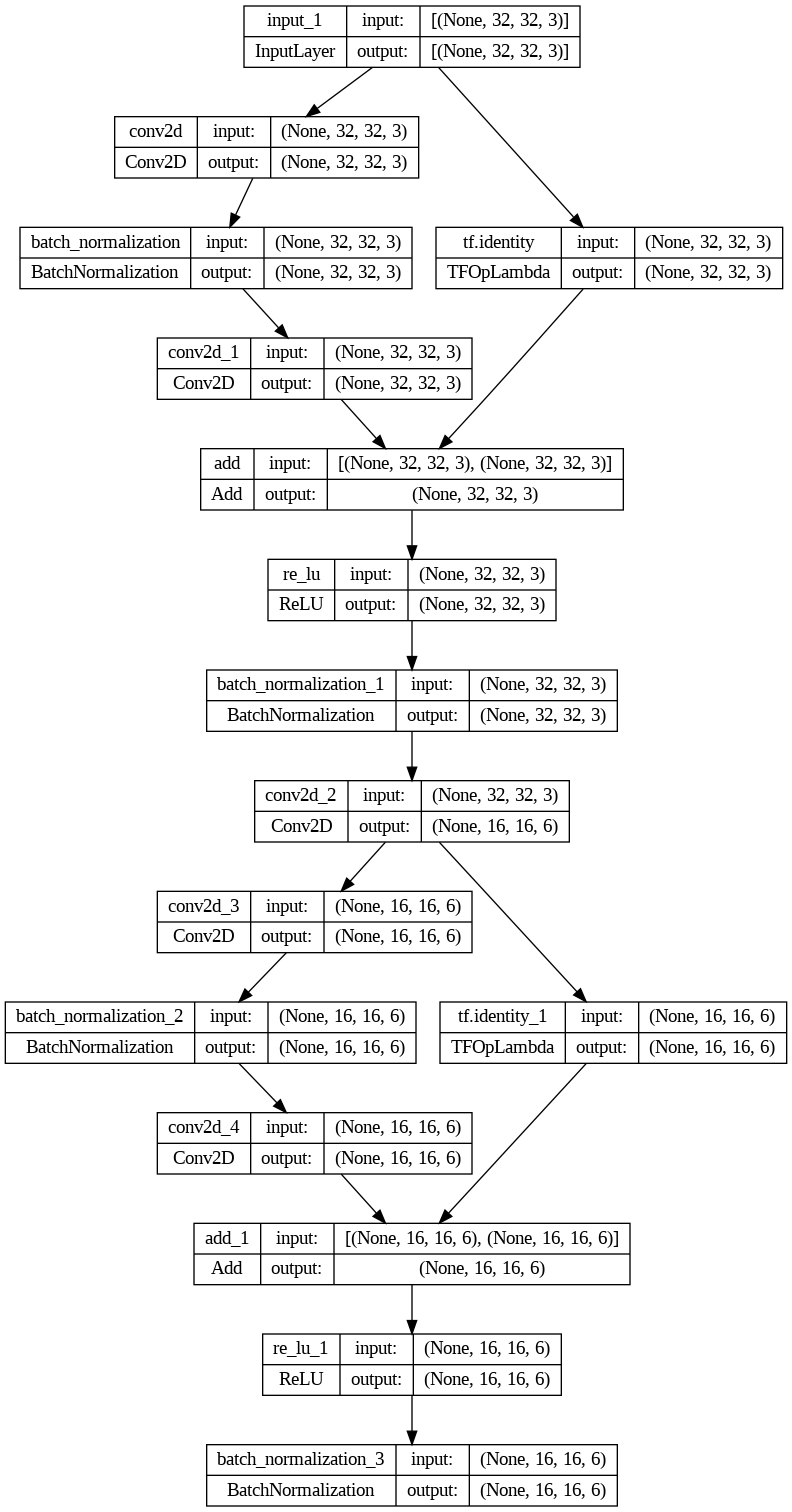

In [ ]:
input = keras.Input(shape=(32,32,3))

x = resblock(input, 3, 3)
x = resize_using_1by1_convolution(x)
x = resblock(x, 6, 3)

model = keras.Model(inputs=input, outputs=x)
keras.utils.plot_model(model, show_shapes=True)

### Testing the resblock_group function

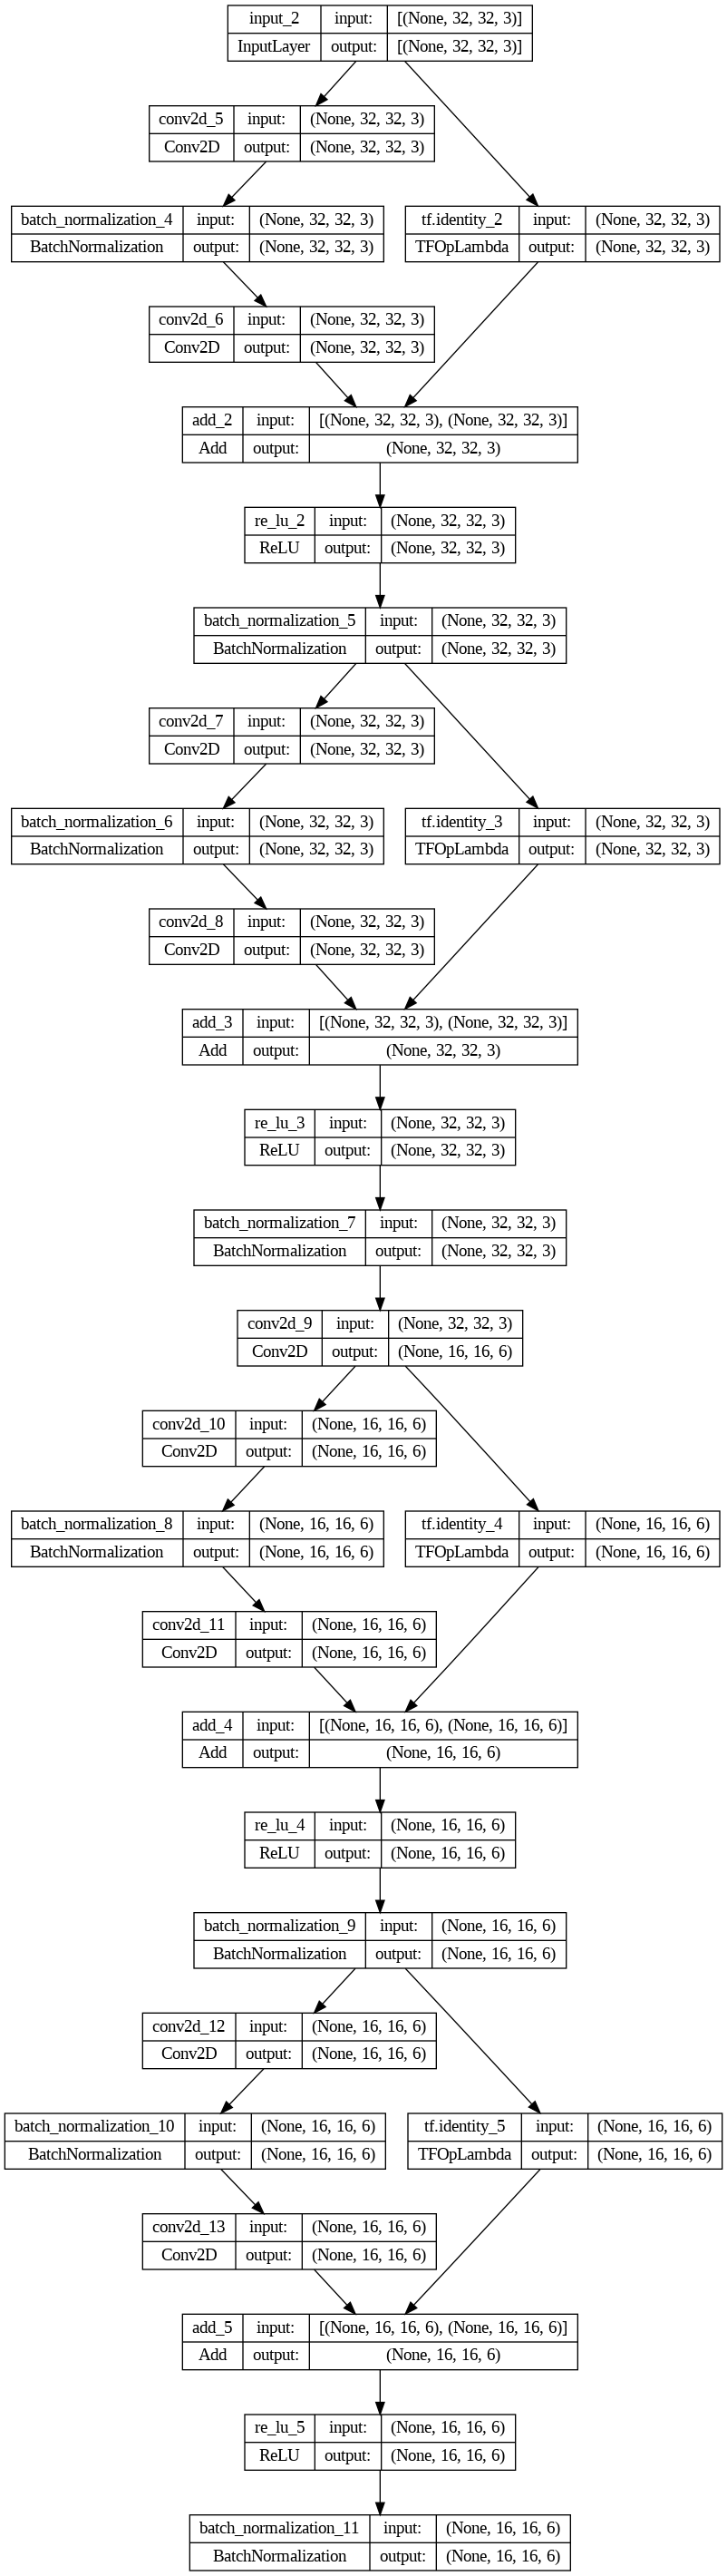

In [ ]:
input = keras.Input(shape=(32,32,3))
x = resblock_group(2, input, 3, 3)
x = resize_using_1by1_convolution(x)
x = resblock_group(2, x, 6, 5)

model = keras.Model(inputs=input, outputs=x)

model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

keras.utils.plot_model(model, show_shapes=True)

# Building a ResNet Model for Cifar-10

## Our own Model

We started with the implementation from the ResNet paper for ImageNet and then tried to adapt it to Cifar-10 as best as possible.

**Main insight**: It has to be way smaller than the model for ImageNet. Probably, this is because of the way smaller images as inputs and the fewer output categories.

### Implementation

In [ ]:
def build_and_compile_own_model():

  def build_own_model():
    input = keras.Input(shape=(32,32,3))
    x = keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, padding="same")(input)
    x = keras.layers.MaxPooling2D()(x)
    x = resize_using_1by1_convolution(x)
    x = resblock_group(2, x, 64, 3)
    x = keras.layers.AveragePooling2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(10)(x)

    model = keras.Model(inputs=input, outputs=x, name="own_model")

    return model

  model = build_own_model()

  model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

  return model

own_model = build_and_compile_own_model()

### Visualization

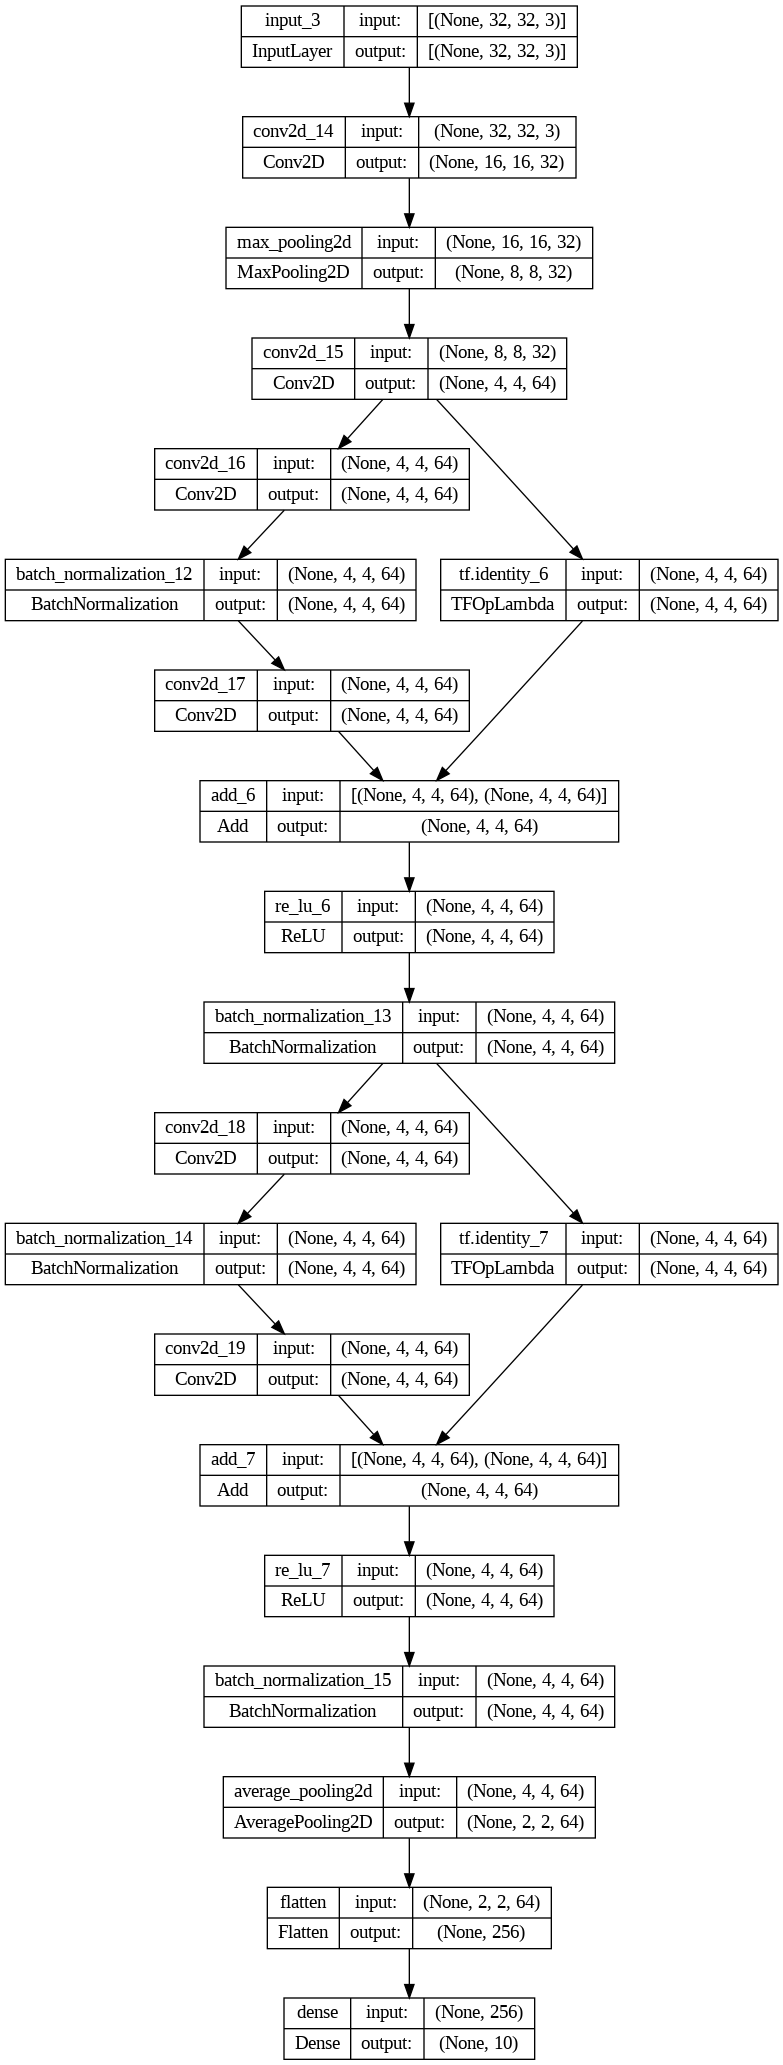

In [ ]:
keras.utils.plot_model(own_model, show_shapes=True)

### Training

In [ ]:
own_model.fit(train_data, epochs=10, steps_per_epoch=1000)

Epoch 1/10
1000/1000 [==============================] - 19s 8ms/step - loss: 1.2676 - accuracy: 0.5479
Epoch 2/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.9169 - accuracy: 0.6745
Epoch 3/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.7082 - accuracy: 0.7511
Epoch 4/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5429 - accuracy: 0.8110
Epoch 5/10
1000/1000 [==============================] - 12s 12ms/step - loss: 0.3949 - accuracy: 0.8631
Epoch 6/10
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2826 - accuracy: 0.9019
Epoch 7/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2081 - accuracy: 0.9285
Epoch 8/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1636 - accuracy: 0.9430
Epoch 9/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1400 - accuracy: 0.9512
Epoch 10/10
1000/1000 [==============================] - 10s 10ms/step - loss

### Evaluation

In [ ]:
own_model.evaluate(test_data)

79/79 [==============================] - 1s 9ms/step - loss: 2.0033 - accuracy: 0.6277


[2.0033352375030518, 0.6276999711990356]

- keep it simple -> small networks perform better
- when training too long it seems that overfitting kicks in easily
- easy to reach 96% accuracy on training data, but hard to balance it to get high accuracy on test data

- batch normalization makes it faster in learning and it achieves better test data accuracy

## Testing a Model we found in a Blog Post
https://towardsdatascience.com/resnets-for-cifar-10-e63e900524e0

### Implementation

In [ ]:
def build_and_compile_model_from_blog_post():

  def build_model_from_blog_post():
    input = keras.Input(shape=(32,32,3))
    out = keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same")(input)
    out = keras.layers.BatchNormalization()(out)
    out = resblock(out, 16, 3)
    out = resize_using_1by1_convolution(out)
    out = resblock(out, 32, 3)
    out = resize_using_1by1_convolution(out)
    out = resblock(out, 64, 3)
    out = keras.layers.AveragePooling2D(pool_size=8)(out)
    out = keras.layers.Flatten()(out)
    out = keras.layers.Dense(10)(out)

    model = keras.Model(inputs=input, outputs=out, name="resnet_from_blog_post")

    return model

  model = build_model_from_blog_post()

  model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

  return model

model_from_blog_post = build_and_compile_model_from_blog_post()

### Visualization

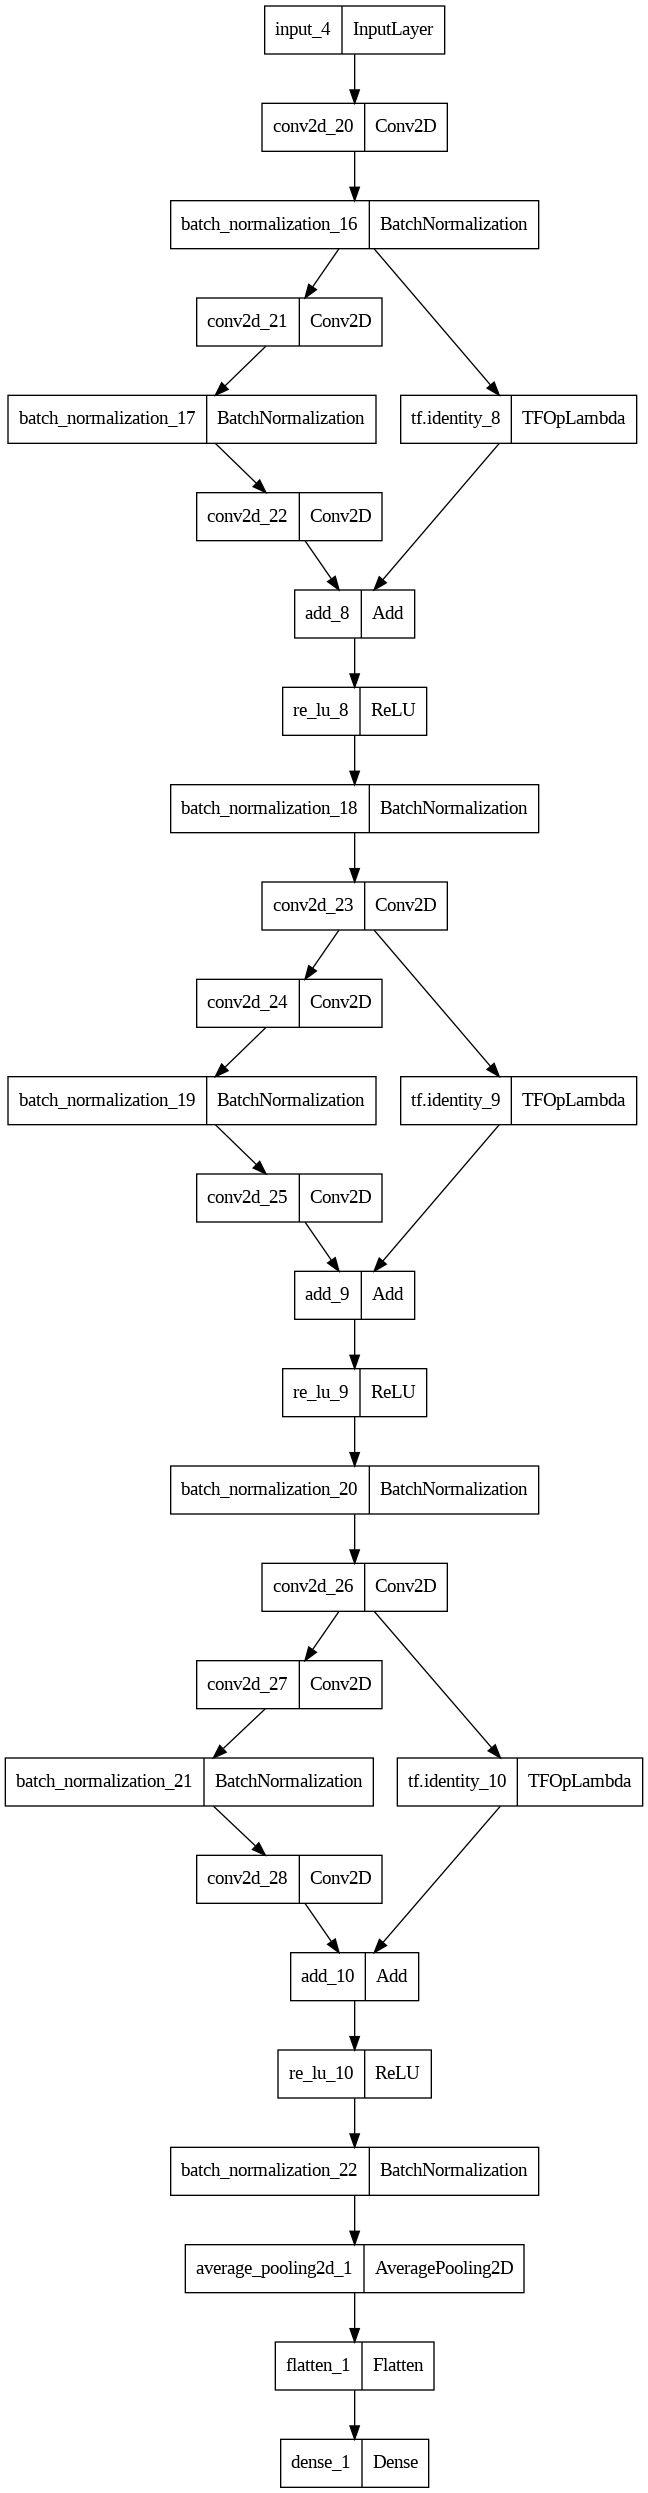

In [ ]:
keras.utils.plot_model(model_from_blog_post)

### Training

In [ ]:
model_from_blog_post.fit(train_data, epochs=10, steps_per_epoch=1000)

Epoch 1/10
1000/1000 [==============================] - 19s 13ms/step - loss: 1.1790 - accuracy: 0.5762
Epoch 2/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.7788 - accuracy: 0.7240
Epoch 3/10
1000/1000 [==============================] - 14s 14ms/step - loss: 0.6167 - accuracy: 0.7839
Epoch 4/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.5107 - accuracy: 0.8217
Epoch 5/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.4329 - accuracy: 0.8498
Epoch 6/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.3655 - accuracy: 0.8732
Epoch 7/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.3108 - accuracy: 0.8922
Epoch 8/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.2573 - accuracy: 0.9102
Epoch 9/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.2209 - accuracy: 0.9241
Epoch 10/10
1000/1000 [==============================] - 13s 13m

### Evaluation

In [ ]:
model_from_blog_post.evaluate(test_data)

79/79 [==============================] - 1s 8ms/step - loss: 1.1008 - accuracy: 0.7320


[1.1008237600326538, 0.7319999933242798]

Result: Performs around 15% better than our own model

## Implementation using custom Layers

### Implementation

In [ ]:
class ResBlock(keras.Model):
  count = 1

  def __init__(self, filters, kernel_size):
    super().__init__(name="ResBlock_"+str(ResBlock.count))
    self.filters=filters
    self.kernel_size=kernel_size

    self.conv1 = keras.layers.Conv2D(filters, kernel_size, activation="relu", padding="same")
    self.bn1 = keras.layers.BatchNormalization()
    self.conv2 = keras.layers.Conv2D(filters, kernel_size, activation="relu", padding="same")
    self.add = keras.layers.Add()
    self.relu = keras.layers.ReLU()
    self.bn2 = keras.layers.BatchNormalization()

    ResBlock.count += 1

  def call(self, inputs):
    if inputs.shape[3] != self.filters:
      raise ValueError(f"Incompatible shape of x: ({inputs.shape}) and amount of filters: {self.filters}")

    x = tf.identity(inputs)
    x_initial = tf.identity(x)

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.conv2(x)

    x = self.add([x_initial, x])
    x = self.relu(x)
    x = self.bn2(x)

    return x


class ResBlockGroup(keras.Model):

  count = 1

  def __init__(self, n: int, filters: int, kernel_size: int):
    super().__init__(name="ResBlockGroup_" + str(ResBlockGroup.count))

    if n < 1:
      raise ValueError("n has to be at least 1")

    self.n = n
    self.filters = filters
    self.kernel_size = kernel_size

    self.res_blocks = [ResBlock(self.filters, self.kernel_size) for _ in range(self.n)]

    ResBlockGroup.count += 1


  def call(self, inputs):
    if inputs.shape[3] != self.filters:
      raise ValueError(f"Incompatible amount of filters and input shape")

    x = inputs

    for res_block in self.res_blocks:
      x = res_block(x)

    return x

  def get_functional_model(self):
    inputs = keras.Input(shape=(32,32,self.filters))

    return keras.Model(inputs=inputs, outputs=self.call(inputs))



class CiFar10ResNetModel(keras.Model):

  def __init__(self):
    super().__init__(name="CiFar10ResNetModel")

    self.res_block_group_1 = ResBlockGroup(3,3,3)
    self.res_block_group_2 = ResBlockGroup(3,6,3)
    self.resize_layer_1 = keras.layers.Conv2D(6,1, 2, padding="same")
    self.avg_pooling = keras.layers.AveragePooling2D(pool_size=2)
    self.flatten = keras.layers.Flatten()
    self.dense = keras.layers.Dense(10, name="Dense")

  def build(self, input_shape):
    pass

  def call(self, input):

    x = self.res_block_group_1(input)
    x = self.resize_layer_1(x)
    x = self.res_block_group_2(x)
    x = self.avg_pooling(x)
    x = self.flatten(x)
    x = self.dense(x)

    return x


  def get_functional_model(self):

    input = keras.Input(shape=(32,32,3))

    return keras.Model(inputs=input, outputs=self.call(input))


### Testing

In [ ]:
cifar10_model = CiFar10ResNetModel()

cifar10_model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

cifar10_model.fit(train_data, epochs=1, steps_per_epoch=10)

cifar10_functional_model = cifar10_model.get_functional_model()


10/10 [==============================] - 7s 16ms/step - loss: 2.4827 - accuracy: 0.1305


### Visualization

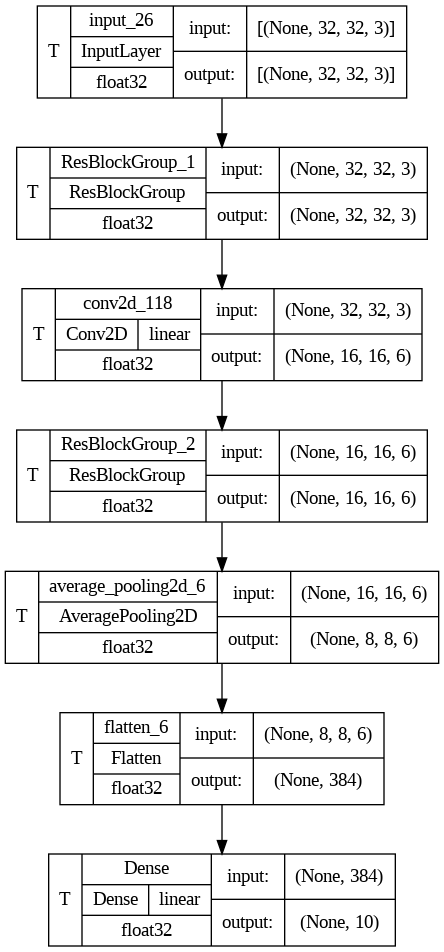

In [ ]:
keras.utils.plot_model(cifar10_functional_model, show_shapes=True, show_dtype=True, expand_nested=True, show_layer_activations=True, show_trainable=True)

# Testing the Speed Difference when using Graph Execution


In [103]:
def measure_execution_time(function):
  start = time.time()
  function()
  end = time.time()

  return end-start


def train_cifar10_model_with_graph_execution():
  tf.config.run_functions_eagerly(False)
  print(f"Currently executing tf functions eagerly: {tf.executing_eagerly()}")
  cifar10_model = CiFar10ResNetModel()

  cifar10_model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

  cifar10_model.fit(train_data, epochs=3, steps_per_epoch=100)

def train_cifar10_model_with_eager_execution():
  tf.config.run_functions_eagerly(True)

  print(f"Currently executing tf functions eagerly: {tf.executing_eagerly()}")
  cifar10_model = CiFar10ResNetModel()

  cifar10_model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])

  cifar10_model.fit(train_data, epochs=3, steps_per_epoch=100)

  tf.config.run_functions_eagerly(False)


print(f"Execution time with graph execution: {round(measure_execution_time(train_cifar10_model_with_graph_execution), 3)}s")
print(f"Execution time with eager execution: {round(measure_execution_time(train_cifar10_model_with_eager_execution), 3)}s")



Currently executing tf functions eagerly: True
Epoch 1/3
100/100 [==============================] - 8s 11ms/step - loss: 2.1754 - accuracy: 0.2177
Epoch 2/3
100/100 [==============================] - 1s 10ms/step - loss: 1.8881 - accuracy: 0.3090
Epoch 3/3
100/100 [==============================] - 1s 10ms/step - loss: 1.7135 - accuracy: 0.3762
Execution time with graph execution: 10.3s
Currently executing tf functions eagerly: True
Epoch 1/3
100/100 [==============================] - 19s 188ms/step - loss: 2.1706 - accuracy: 0.2349
Epoch 2/3
100/100 [==============================] - 18s 184ms/step - loss: 1.7992 - accuracy: 0.3575
Epoch 3/3
100/100 [==============================] - 19s 194ms/step - loss: 1.6764 - accuracy: 0.3876
Execution time with eager execution: 56.937s


**Result**: Graph execution is around 6x faster than eager execution.

For some reason the output says, that the graph execution version also uses eager execution. No idea why that is because eager execution should be explicitly deactivated beforehand.